#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [104]:
df_stock1 = pd.read_csv("../static/data/cba.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df_stock3 = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock3.iloc[:-1,:]
# Drop last 3 columns sentiment RBA FED
N=3
df = df_stock_less1.iloc[: , :-N]
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,3/01/2000,26.088652,26.088652,26.088652,26.088652,7.993308,0
1,4/01/2000,26.058813,26.058813,25.720646,25.790268,7.901886,1018072
2,5/01/2000,25.353634,25.392424,25.113932,25.213392,7.725136,2191283
3,6/01/2000,25.362585,25.362585,24.666357,24.716087,7.572770,1505531
4,7/01/2000,24.913021,25.113932,24.735979,24.964741,7.648952,1414040


<AxesSubplot:>

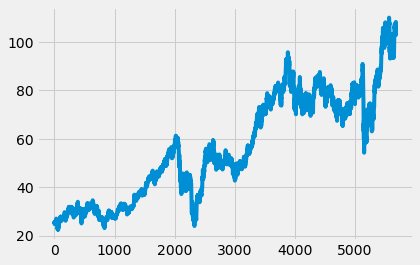

In [105]:
df["Close"].plot()

In [106]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5681 entries, 0 to 5680
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5681 non-null   object 
 1   Open       5681 non-null   float64
 2   High       5681 non-null   float64
 3   Low        5681 non-null   float64
 4   Close      5681 non-null   float64
 5   Adj Close  5681 non-null   float64
 6   Volume     5681 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 355.1+ KB


In [107]:
data = df.filter(['Close'])
dataset = data.values
dataset.shape


(5681, 1)

# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [108]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(4545, 1)

In [109]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.04184307, 0.03844119, 0.03186422, 0.02619443, 0.02902934,
       0.03583307, 0.03112717, 0.0329982 , 0.03073027, 0.03450637,
       0.0379876 , 0.03712579, 0.03129727, 0.03469913, 0.03390536,
       0.03469913, 0.0329982 , 0.0329982 , 0.03776081, 0.04218326,
       0.04036892, 0.03544755, 0.03531146, 0.03016329, 0.03424555,
       0.03549291, 0.03408679, 0.03696705, 0.04090187, 0.0449728 ,
       0.04610676, 0.05227547, 0.04921377, 0.04036892, 0.04110597,
       0.03708043, 0.0399607 , 0.04127609, 0.03932567, 0.03889476,
       0.03056017, 0.02780467, 0.03696705, 0.03526612, 0.03062821,
       0.02789536, 0.0244935 , 0.0244935 , 0.0244935 , 0.00521622,
       0.00657697, 0.00635016, 0.01099939, 0.0086521 , 0.00521622,
       0.00510283, 0.00147414, 0.00136076, 0.00011341, 0.00100922])]
[0.002086477591719982]


# Prepare train data for LSTM model

In [110]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(4485, 60)

In [111]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4485, 60, 1)

# Build the LSTM model

In [112]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [113]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [114]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

4485/4485 [==============================] - 67s 15ms/step - loss: 7.0460e-04


In [115]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [116]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [117]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [118]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.9288019177179471

In [119]:
# date_time = df["Date"]
# date_time = pd.to_datetime(date_time)
# data = data.set_index(date_time)

C:\Users\antoi\AppData\Local\Temp/ipykernel_3288/2169877764.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


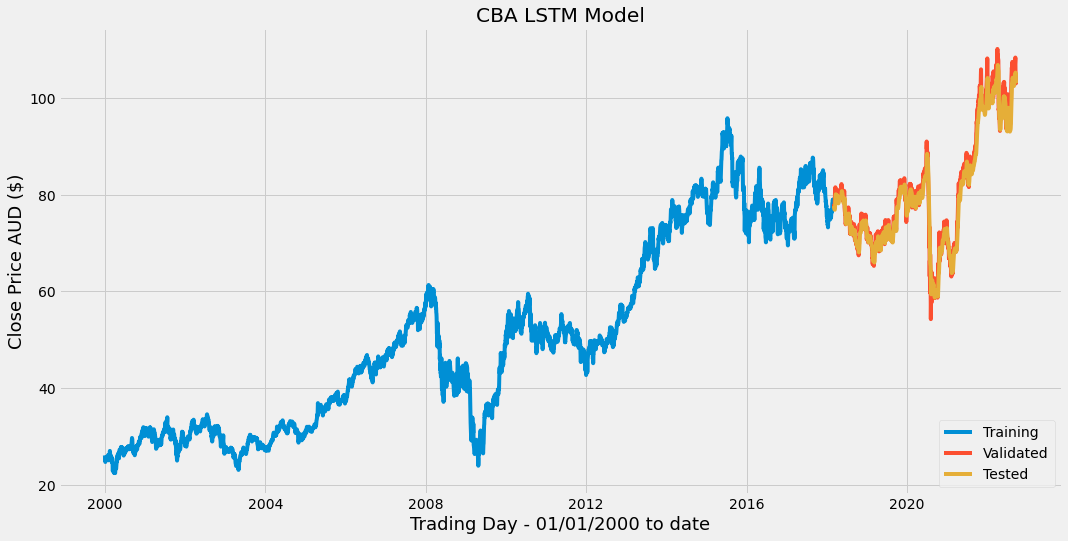

In [120]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('CBA LSTM Model')
plt.xlabel('Trading Day - 01/01/2000 to date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validated','Tested'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.show()


# Test data Predictions on the Model

In [121]:
valid['Difference']= valid['Close']-valid['Predictions']
valid

C:\Users\antoi\AppData\Local\Temp/ipykernel_3288/3952761259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


,Close,Predictions,Difference
4545,77.629997,77.640457,-0.010460
4546,77.669998,77.384842,0.285156
4547,77.410004,77.177635,0.232369
4548,77.790001,76.983681,0.806320
4549,77.400002,76.940788,0.459214
...,...,...,...
5676,108.349998,104.838181,3.511817
5677,105.370003,105.241783,0.128220
5678,104.750000,104.831177,-0.081177
5679,103.000000,104.121613,-1.121613


In [122]:
#Get latest 60 quotes less 1 to predict:

#import pandas_datareader.data as web
#symbol = 'CBA.AX'
#stock_quote = web.DataReader(symbol,data_source='yahoo',start='2022-01-01', end='2022-04-13')
#stock_quotes_sixty = stock_quotes_sixty.filter(['Close'])
#stock_quotes_sixty
#OR use csv data 

In [123]:
# Use last 60 days price on model to predict next days price
stock_quotes_sixty = df_stock_less1.tail(60)
stock_close_sixty = stock_quotes_sixty['Close']
last_60_days_val = stock_close_sixty[-60:].values
last_60_days = last_60_days_val.reshape(-1,1)
last_60_days.shape

(60, 1)

In [124]:
last_60_days_scaled = scaler.transform(last_60_days)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [125]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = int(pred_price)
print(f'Predicted next day share price {pred_price}')

Predicted next day share price 102


In [126]:
#stock_quote_acual = web.DataReader('CBA.AX',data_source='yahoo',start='2022-04-14', end='2022-04-14')
#OR get last quote from latest csv
stock_quote_last_one = df_stock1.tail(1)
stock_quote_last_one

,Date,Open,High,Low,Close,Adj Close,Volume,SENTIMENT,RBA,FED
5681,29/04/2022,103.800003,104.190002,103.389999,103.419998,103.419998,896198,POSITIVE,0.05,0.08


In [127]:
#save actual to variable
actual_price = stock_quote_last_one.iloc[0,4]
actual_date = stock_quote_last_one.iloc[0,0] 
actual_price = int(actual_price)
actual_price
actual_date

'29/04/2022'

# Save the Model

In [128]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/cba_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list cba_sixty and load df

In [129]:
# Read in the CSV file
df_cba_sixty = pd.read_csv("../static/data/cba_sixty.csv")
df_cba_sixty.tail()

,92.277802
55,105.370003
56,104.750000
57,103.000000
58,103.230003
59,103.419998


In [130]:
close_sixty_val = df_cba_sixty[-60:].values
last_sixty = close_sixty_val.reshape(-1,1)
last_sixty.shape

(60, 1)

In [131]:
last_sixty_scaled = scaler.transform(last_sixty)
new_X_tell = []
new_X_tell.append(last_sixty_scaled)
new_X_tell =np.array(new_X_tell)
new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
new_X_tell.shape

(1, 60, 1)

In [132]:
#PREDICT USING LOADED MODEL

In [133]:
from keras.models import load_model

In [134]:
model_in = load_model('../static/cba_model.sav')

In [135]:
model_in_pd_scale = model_in.predict(new_X_tell)
model_in_pd_scale

array([[0.90464336]], dtype=float32)

In [136]:
model_in_price = scaler.inverse_transform(model_in_pd_scale)
#model_in_price_int = int(model_in_price)
print(f'Predicted next day share price {model_in_price}')

Predicted next day share price [[101.76612]]


In [137]:
last_sixty_less_one = np.delete(last_sixty, 0, 0)
last_sixty_less_one.shape

(59, 1)

In [138]:
last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0)
last_sixty.shape

(60, 1)

#Create a function to loop through the days input

In [139]:
from keras.models import load_model
model_in = load_model('../static/cba_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
# Read in the CSV file
df_cba_sixty = pd.read_csv("../static/data/cba_sixty.csv")

close_sixty_val = df_cba_sixty[-60:].values
last_sixty = close_sixty_val.reshape(-1,1)

price_list=[]

#Function to predict future days predicted price, in loop
input = 10 #days
if input == "":
    input = 200
else:
   input = int(input)

def predict_cba(last_sixty,model_in,input):
    for i in range(0, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    print(price_list)
   

In [140]:
predict_cba(last_sixty,model_in,input)

0
Day finished! Price: 
1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
Could not predict further!
10
[103.54, 103.35, 103.29, 103.27, 103.29, 103.33, 103.35, 103.37, 103.39, 103.4]


In [142]:
#input = 10
dates_df = pd.read_csv("../static/data/dates.csv")
dates_df_iloc = dates_df.iloc[0:input]
dates_df_iloc['Price'] = price_list
my_dict = dates_df_iloc.to_dict(orient='records')
my_dict

C:\Users\antoi\AppData\Local\Temp/ipykernel_3288/2903849286.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


[{'Count': 1.0, 'Date': '3/05/2022', 'DOW': 'Tuesday', 'Price': 103.54},
 {'Count': 2.0, 'Date': '4/05/2022', 'DOW': 'Wednesday', 'Price': 103.35},
 {'Count': 3.0, 'Date': '5/05/2022', 'DOW': 'Thursday', 'Price': 103.29},
 {'Count': 4.0, 'Date': '6/05/2022', 'DOW': 'Friday', 'Price': 103.27},
 {'Count': 5.0, 'Date': '9/05/2022', 'DOW': 'Monday', 'Price': 103.29},
 {'Count': 6.0, 'Date': '10/05/2022', 'DOW': 'Tuesday', 'Price': 103.33},
 {'Count': 7.0, 'Date': '11/05/2022', 'DOW': 'Wednesday', 'Price': 103.35},
 {'Count': 8.0, 'Date': '12/05/2022', 'DOW': 'Thursday', 'Price': 103.37},
 {'Count': 9.0, 'Date': '13/05/2022', 'DOW': 'Friday', 'Price': 103.39},
 {'Count': 10.0, 'Date': '16/05/2022', 'DOW': 'Monday', 'Price': 103.4}]

In [143]:
# price_dict = dict({"Price": price_list}) 
#dates_dict =  dates_df.to_dict(orient='records')
#dates_dict
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
price_dict

[{'Price': 103.54},
 {'Price': 103.35},
 {'Price': 103.29},
 {'Price': 103.27},
 {'Price': 103.29},
 {'Price': 103.33},
 {'Price': 103.35},
 {'Price': 103.37},
 {'Price': 103.39},
 {'Price': 103.4}]

In [144]:
# DRAW THE PREDICTION
df_len = len(df.index) # length of the original dataframe
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs
print(train_data_len,df_len,len_pred_df)
new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)

4545 5681 5691


,Close
5681,103.54
5682,103.35
5683,103.29
5684,103.27
5685,103.29
5686,103.33
5687,103.35
5688,103.37
5689,103.39
5690,103.40


C:\Users\antoi\AppData\Local\Temp/ipykernel_3288/3422036737.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


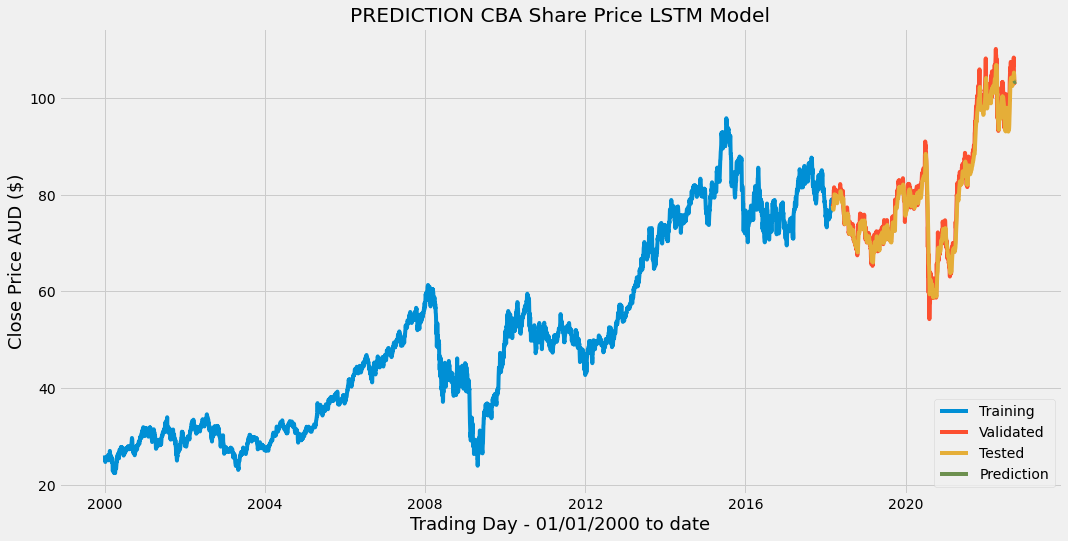

In [145]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:df_len] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[df_len:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION CBA Share Price LSTM Model')
plt.xlabel('Trading Day - 01/01/2000 to date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training','Validated','Tested','Prediction'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.show()

#Save predicted price to MongoDB

In [ ]:
# # Module used to connect Python with MongoDb
# import pymongo

In [ ]:
# # The default port used by MongoDB is 27017
# # https://docs.mongodb.com/manual/reference/default-mongodb-port/
# conn = 'mongodb://localhost:27017'
# client = pymongo.MongoClient(conn)

# # Define the 'sharesDB' database in Mongo
# db = client.sharesDB

In [ ]:
# # Query all
# # Here, db.companys refers to the collection 'companys '
# companys = db.companys.find()

# # Iterate through each company in the collection
# for company in companys:
#     print(company)

In [ ]:
# # Set keys and values of company
# name = 'CBA'
# predicted = int(pred_price)
# difference = pred_price-actual_price
# print(f'date {actual_date},predicted {predicted},actual {actual_price}, difference {difference}')

In [ ]:
# # Insert a document into the 'companys' collection
# db.companys.insert_one(
#     {
#       'model': 'LSTM',
#       'name': name,
#       'date': actual_date,
#       'predicted': predicted,
#       'actual': actual_price,
#       'differece': difference
#     }
# )

# # query the classroom collection
# companys = db.companys.find()

# # see change in collection
# for company in companys:
#     print(company)

In [ ]:
# # Delete a document from a collection
# db.companys.delete_one(
#     {'name': 'CBA'}
# )

# # query the companys collection
# companys = db.companys.find()

# # see change in the collection
# for company in companys:
#     print(company)

In [ ]:
# from pymongo import MongoClient
# mongoClient = MongoClient()
# db = mongoClient.sharesDB
# db.cba.drop()

# import csv
# header = ["Date","Open","High","Low","Close","Adj Close","Volume","SENTIMENT","RBA","FED"]
# csvfile = open('../static/data/cba.csv', 'r')
# reader = csv.DictReader( csvfile )

# for each in reader:
#     row={}
#     for field in header:
#         row[field]=each[field]
        
#     print (row)
#     db.cba.insert_one(row)				 				

In [ ]:
# # query the collection
# cbas = db.cba.find()

# # see change in collection
# for cba in cbas:
#     print(cba)

In [ ]:
# from pymongo import MongoClient
# mongoClient = MongoClient()
# db = mongoClient.sharesDB
# db.cba_scatter.drop()

# import csv
# header = ["Date","Open","High","Low","Close","Adj Close","Volume","SENTIMENT","RBA","FED"]
# csvfile = open('../static/data/cba_scatter.csv', 'r')
# reader = csv.DictReader( csvfile )

# for each in reader:
#     row={}
#     for field in header:
#         row[field]=each[field]
        
#     print (row)
#     db.cba_scatter.insert_one(row)				 				